In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("A3 Experimental Data - Sheet1.csv")
df = df.iloc[: , :-1]

df.tail()

,Id,Date,Type,TrueValue,GuessValue,Error,Point1,Point2
734,ekytc,2/14/2024 6:59:17,Radar,76.595745,70,2.75,36,47
735,ekytc,2/14/2024 6:59:29,Bar,26.865672,24,1.58,18,67
736,ekytc,2/14/2024 6:59:43,Pie,56.896552,62,2.39,33,58
737,ekytc,2/14/2024 6:59:58,Radar,5.263158,3,1.26,1,19
738,ekytc,2/14/2024 7:00:15,Bar,9.333333,8,0.54,7,75


In [2]:
df["Type"].value_counts()

Radar    249
Pie      248
Bar      242
Name: Type, dtype: int64

In [3]:
df.groupby("Type")["Error"].agg(["mean", "std"])

,mean,std
Type,,
Bar,1.773678,1.910976
Pie,2.212944,2.036939
Radar,2.728153,1.910636


In [4]:
pie = df[df['Type'] == 'Pie']['Error']
radar = df[df['Type'] == 'Radar']['Error']
bar = df[df['Type'] == 'Bar']['Error']

# pie.head()

In [5]:
from scipy.stats import sem
from sklearn.utils import resample


def bootstrap_confidence_interval(data, n_bootstrap, alpha):
    bootstrap_errors = []
    for Vis in range(n_bootstrap):
        sample = resample(data)
        error_mean = sample.mean()
        bootstrap_errors.append(error_mean)
        
    mean_error = np.mean(bootstrap_errors)
    lower_bound = np.percentile(bootstrap_errors, (1-alpha)/2 * 100)
    upper_bound = np.percentile(bootstrap_errors, (1+alpha)/2 * 100)
    return lower_bound, mean_error, upper_bound

n_bootstrap = 1000  
alpha = 0.05

pie_ci = bootstrap_confidence_interval(pie, n_bootstrap, alpha)
radar_ci = bootstrap_confidence_interval(radar, n_bootstrap, alpha)
bar_ci = bootstrap_confidence_interval(bar, n_bootstrap, alpha)

print("Bootstrap Lower, Mean, and Upper Bound for Pie Error:", pie_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Radar Error:", radar_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Bar Error:", bar_ci)

Bootstrap Lower, Mean, and Upper Bound for Pie Error: (2.200555443548387, 2.209232620967742, 2.2149576612903226)
Bootstrap Lower, Mean, and Upper Bound for Radar Error: (2.714899598393573, 2.724810281124498, 2.730621485943775)
Bootstrap Lower, Mean, and Upper Bound for Bar Error: (1.7714958677685955, 1.7772047933884294, 1.7850506198347103)


# Confidence Interval Visualization

/var/folders/0v/8nnlrzmn2g33vwz78930kzs80000gn/T/ipykernel_7470/2204803761.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(mean, y, 'ro', color='black')


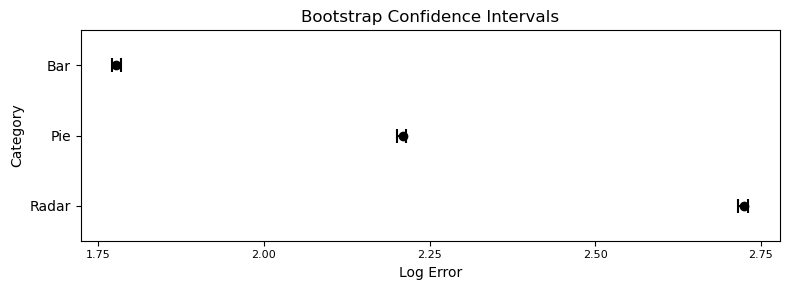

In [6]:
import pandas as pd
from matplotlib import pyplot as plt

data_dict = {}
data_dict['category'] = ['Bar', 'Pie', 'Radar']
data_dict['lower'] = [[bar_ci[0]],[pie_ci[0]], [radar_ci[0]]]
data_dict['mean'] = [[bar_ci[1]],[pie_ci[1]],[radar_ci[1]]]
data_dict['upper'] = [[bar_ci[2]], [pie_ci[2]],[radar_ci[2]]]
dataset = pd.DataFrame(data_dict)


category_order = ['Radar', 'Pie', 'Bar']
dataset['category'] = pd.Categorical(dataset['category'], categories=category_order, ordered=True)
dataset = dataset.sort_values(by='category')

plt.figure(figsize=(8, 3))

for lower, mean, upper, y, label in zip(dataset['lower'], dataset['mean'], dataset['upper'], range(len(dataset)), dataset['category']):
    plt.vlines(lower, y - 0.1, y + 0.1, colors='black', linestyles='solid')
    plt.vlines(upper, y - 0.1, y + 0.1, colors='black', linestyles='solid')
    plt.plot(mean, y, 'ro', color='black')
    plt.hlines(y, lower, upper, colors='black', linestyles='solid')

plt.yticks(range(len(dataset)), list(dataset['category']))
plt.xlabel('Log Error')
plt.ylabel('Category')
plt.title('Bootstrap Confidence Intervals')
plt.ylim(-0.5, len(dataset) - 0.5)  
plt.xticks(fontsize=8)

ticks = [1.75, 2.0, 2.25, 2.5, 2.75]
plt.xticks(ticks)

# plt.grid(True)
plt.tight_layout() 
plt.show()

# Time

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Id', 'Date'])
df['TimePerGuess'] = df.groupby('Id')['Date'].diff().dt.total_seconds()

# Time for each guess relative to the previous guess

print(df.head(20))
print(df.groupby('Type')['TimePerGuess'].mean())

        Id                Date   Type  TrueValue  GuessValue  Error  Point1  \
286  1harg 2024-02-11 22:37:32    Bar  14.925373          50   0.00      10   
287  1harg 2024-02-11 22:37:44    Bar  14.925373           5   3.33      10   
288  1harg 2024-02-11 22:37:57    Bar  89.743590          25   6.02      35   
289  1harg 2024-02-11 22:38:38  Radar  86.904762          80   2.81      73   
290  1harg 2024-02-11 22:38:47    Bar  60.526316          50   3.41      46   
291  1harg 2024-02-11 22:39:06  Radar  95.121951          30   6.03      39   
292  1harg 2024-02-11 22:39:16    Pie  10.606061           9   0.79       7   
293  1harg 2024-02-11 22:39:25    Pie   8.045977           5   1.66       7   
294  1harg 2024-02-11 22:39:32    Bar   6.410256           2   2.18       5   
295  1harg 2024-02-11 22:39:37    Pie  18.367347          18  -1.02       9   
296  1harg 2024-02-11 22:39:43    Bar   4.411765           2   1.34       3   
297  1harg 2024-02-11 22:39:48    Bar   9.090909    

In [12]:
pieT = df[df['Type'] == 'Pie']['TimePerGuess']
radarT = df[df['Type'] == 'Radar']['TimePerGuess']
barT = df[df['Type'] == 'Bar']['TimePerGuess']

pie_ci = bootstrap_confidence_interval(pieT, n_bootstrap, alpha)
radar_ci = bootstrap_confidence_interval(radarT, n_bootstrap, alpha)
bar_ci = bootstrap_confidence_interval(barT, n_bootstrap, alpha)

print("Bootstrap Lower, Mean, and Upper Bound for Pie Time:", pie_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Radar Time:", radar_ci)
print("Bootstrap Lower, Mean, and Upper Bound for Bar Time:", bar_ci)

Bootstrap Lower, Mean, and Upper Bound for Pie Time: (22.183987603305784, 23.23194531452423, 22.709700582576886)
Bootstrap Lower, Mean, and Upper Bound for Radar Time: (79.34836761603376, 83.65193666760638, 83.48825632610027)
Bootstrap Lower, Mean, and Upper Bound for Bar Time: (308.3996084576675, 322.5204181051618, 311.56861924686194)


/var/folders/0v/8nnlrzmn2g33vwz78930kzs80000gn/T/ipykernel_7470/727574357.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(mean, y, 'ro', color='black')


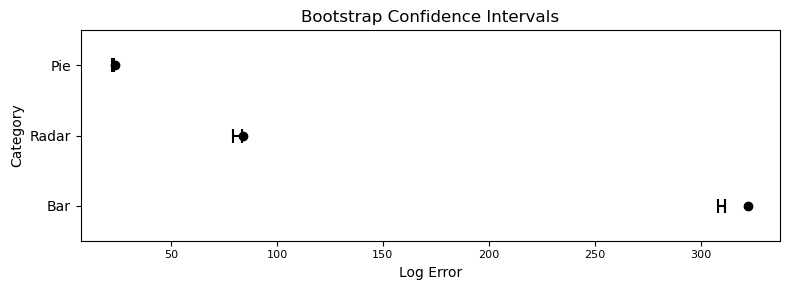

In [21]:
data_dict = {}
data_dict['category'] = ['Bar', 'Pie', 'Radar']
data_dict['lower'] = [[bar_ci[0]],[pie_ci[0]], [radar_ci[0]]]
data_dict['mean'] = [[bar_ci[1]],[pie_ci[1]],[radar_ci[1]]]
data_dict['upper'] = [[bar_ci[2]], [pie_ci[2]],[radar_ci[2]]]
dataset = pd.DataFrame(data_dict)


category_order = ['Bar', 'Radar', 'Pie']
dataset['category'] = pd.Categorical(dataset['category'], categories=category_order, ordered=True)
dataset = dataset.sort_values(by='category')

plt.figure(figsize=(8, 3))

for lower, mean, upper, y, label in zip(dataset['lower'], dataset['mean'], dataset['upper'], range(len(dataset)), dataset['category']):
    plt.vlines(lower, y - 0.1, y + 0.1, colors='black', linestyles='solid')
    plt.vlines(upper, y - 0.1, y + 0.1, colors='black', linestyles='solid')
#     plt.text(lower - 0.03, y + 0.05, f"{lower:.2f}", color='orange', fontsize=8)
#     plt.text(upper - 0.03, y + 0.05, f"{upper:.2f}", color='orange', fontsize=8)
    plt.plot(mean, y, 'ro', color='black')
#     plt.text(mean - 0.03, y - 0.1, f"{mean:.2f}", color='green', fontsize=8)
    plt.hlines(y, lower, upper, colors='black', linestyles='solid')

plt.yticks(range(len(dataset)), list(dataset['category']))
plt.xlabel('Log Error')
plt.ylabel('Category')
plt.title('Bootstrap Confidence Intervals')
plt.ylim(-0.5, len(dataset) - 0.5)  
plt.xticks(fontsize=8)

# plt.grid(True)
plt.tight_layout() 
plt.show()

# Outliers

In [18]:
Q1 = df['TimePerGuess'].quantile(0.05)
Q3 = df['TimePerGuess'].quantile(0.95)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df['TimePerGuess'] < lower_bound) | (df['TimePerGuess'] > upper_bound)]

print("Outliers:")
print(outliers)

Outliers:
         Id                Date   Type  TrueValue  GuessValue  Error  Point1  \
86    1zspd 2024-02-11 13:53:56    Bar  56.097561           5   5.68      46   
154   1zspd 2024-02-11 18:05:19  Radar  37.333333           8   4.88      28   
161   1zspd 2024-02-11 18:12:15    Pie  20.779221          34   3.74      16   
163   1zspd 2024-02-11 18:38:29  Radar  96.000000          34   5.96      48   
347   1zspd 2024-02-12 13:56:19    Bar  25.454545          34   3.12      14   
371   1zspd 2024-02-12 14:00:21    Pie  36.666667          50   3.75      22   
423   1zspd 2024-02-12 14:05:59  Radar  79.545455          98   4.22      35   
562   5gzdh 2024-02-12 17:28:24  Radar  63.829787          40   4.58      30   
459  a66mji 2024-02-12 15:21:34  Radar  81.132075          80   0.33      43   
469  a66mji 2024-02-12 15:23:15    Pie  13.235294           7   2.67       9   
115   aizcu 2024-02-11 14:32:58  Radar  16.666667          16  -0.34      12   
438   oh1ka 2024-02-12 15:16:2

In [24]:
id = "1zspd"
filtered_df = df[df['Id'] == id]

# Print the filtered DataFrame
print(filtered_df)

        Id                Date   Type  TrueValue  GuessValue  Error  Point1  \
5    1zspd 2024-02-11 13:18:51    Bar  74.418605          50   0.00      32   
6    1zspd 2024-02-11 13:19:06    Bar  74.418605          28   5.54      32   
7    1zspd 2024-02-11 13:19:22    Pie  61.363636          10   5.69      27   
8    1zspd 2024-02-11 13:19:34    Bar  92.000000           5   6.45      69   
9    1zspd 2024-02-11 13:19:46  Radar  92.553191           5   6.45      87   
..     ...                 ...    ...        ...         ...    ...     ...   
410  1zspd 2024-02-12 14:04:10    Pie  27.027027          25   1.11      10   
423  1zspd 2024-02-12 14:05:59  Radar  79.545455          98   4.22      35   
430  1zspd 2024-02-12 14:06:39    Bar  54.545455          55  -0.79      42   
432  1zspd 2024-02-12 14:06:48    Pie  18.918919          34   3.93      14   
434  1zspd 2024-02-12 14:07:00    Pie  61.111111          50   3.49      11   

     Point2  TimePerGuess  
5        43           N